# Figure7

**Results**

For all modifications: plot 3 x 5
* PCA on peaks union for all marks
* PCA on DMRs for all marks
* K27me3/K4me1 ratio for DMRs UP/Down/All
* K27me3/K4me1 ration on union peaks / concat peaks / simmetric difference
* All marks combinations ratios on corresponding concat peaks
* All marks combinations on union weak consensus peaks

**Input**
```
export WASHU_ROOT="/mnt/stripe/washu"
export PYTHONPATH="$WASHU_ROOT:$PYTHONPATH"
export WASHU_PARALLELISM=20
DIR=$(pwd); for M in H3K27ac H3K27me3 H3K36me3 H3K4me1 H3K4me3; do     
    echo "Processing $M";      
    PEAKS=$(ls /mnt/stripe/bio/experiments/configs/Y20O20/loci_of_interest/weak_consensus/${M}_span_weak_consensus.bed);     
    echo "Peaks $PEAKS";     
    bash /mnt/stripe/washu/downstream/signals/signals.sh  $DIR/$M 150 /mnt/stripe/bio/experiments/configs/Y20O20/loci_of_interest/ /mnt/stripe/bio/genomes/hg19/hg19.chrom.sizes $PEAKS;     
done 2>&1 | tee log.txt
```

In [ ]:
# Initialization
%matplotlib inline
%config InlineBackend.figure_format='retina'

import re
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from IPython.display import display
from downstream.aging import *

# Explicitly setup style
plt.style.use('seaborn-darkgrid')

MARKS=['H3K27ac', 'H3K27me3', 'H3K36me3', 'H3K4me1', 'H3K4me3']

NORMALIZATIONS = ['fripm', 
                  'diffbind_tmm_minus_full', 'diffbind_tmm_reads_full_cpm', 'diffbind_tmm_reads_effective_cpm']

AGE_PALETTE = {'Old': '#E41A1C', 'Young': '#377EB8'}

%run /mnt/stripe/washu/downstream/signals/signals_visualize.py

# PCA on weak consensus / DMRs

Plotting everything on a single plot
Processing /mnt/stripe/figures/pca_peaks_dmrs_rpm.pdf
/mnt/stripe/bio/experiments/signal_experiment/H3K27ac/150/H3K27ac_span_weak_consensus/H3K27ac_span_weak_consensus_rpm.tsv
/mnt/stripe/bio/experiments/signal_experiment/H3K27me3/150/H3K27me3_span_weak_consensus/H3K27me3_span_weak_consensus_rpm.tsv
/mnt/stripe/bio/experiments/signal_experiment/H3K36me3/150/H3K36me3_span_weak_consensus/H3K36me3_span_weak_consensus_rpm.tsv
/mnt/stripe/bio/experiments/signal_experiment/H3K4me1/150/H3K4me1_span_weak_consensus/H3K4me1_span_weak_consensus_rpm.tsv
/mnt/stripe/bio/experiments/signal_experiment/H3K4me3/150/H3K4me3_span_weak_consensus/H3K4me3_span_weak_consensus_rpm.tsv
/mnt/stripe/bio/experiments/signal_experiment/H3K27ac/150/dmrs_filtered_ncyto_ge3_abs_avgdiff_ge0.025/dmrs_filtered_ncyto_ge3_abs_avgdiff_ge0.025_rpm.tsv
/mnt/stripe/bio/experiments/signal_experiment/H3K27me3/150/dmrs_filtered_ncyto_ge3_abs_avgdiff_ge0.025/dmrs_filtered_ncyto_ge3_abs_avgdiff_

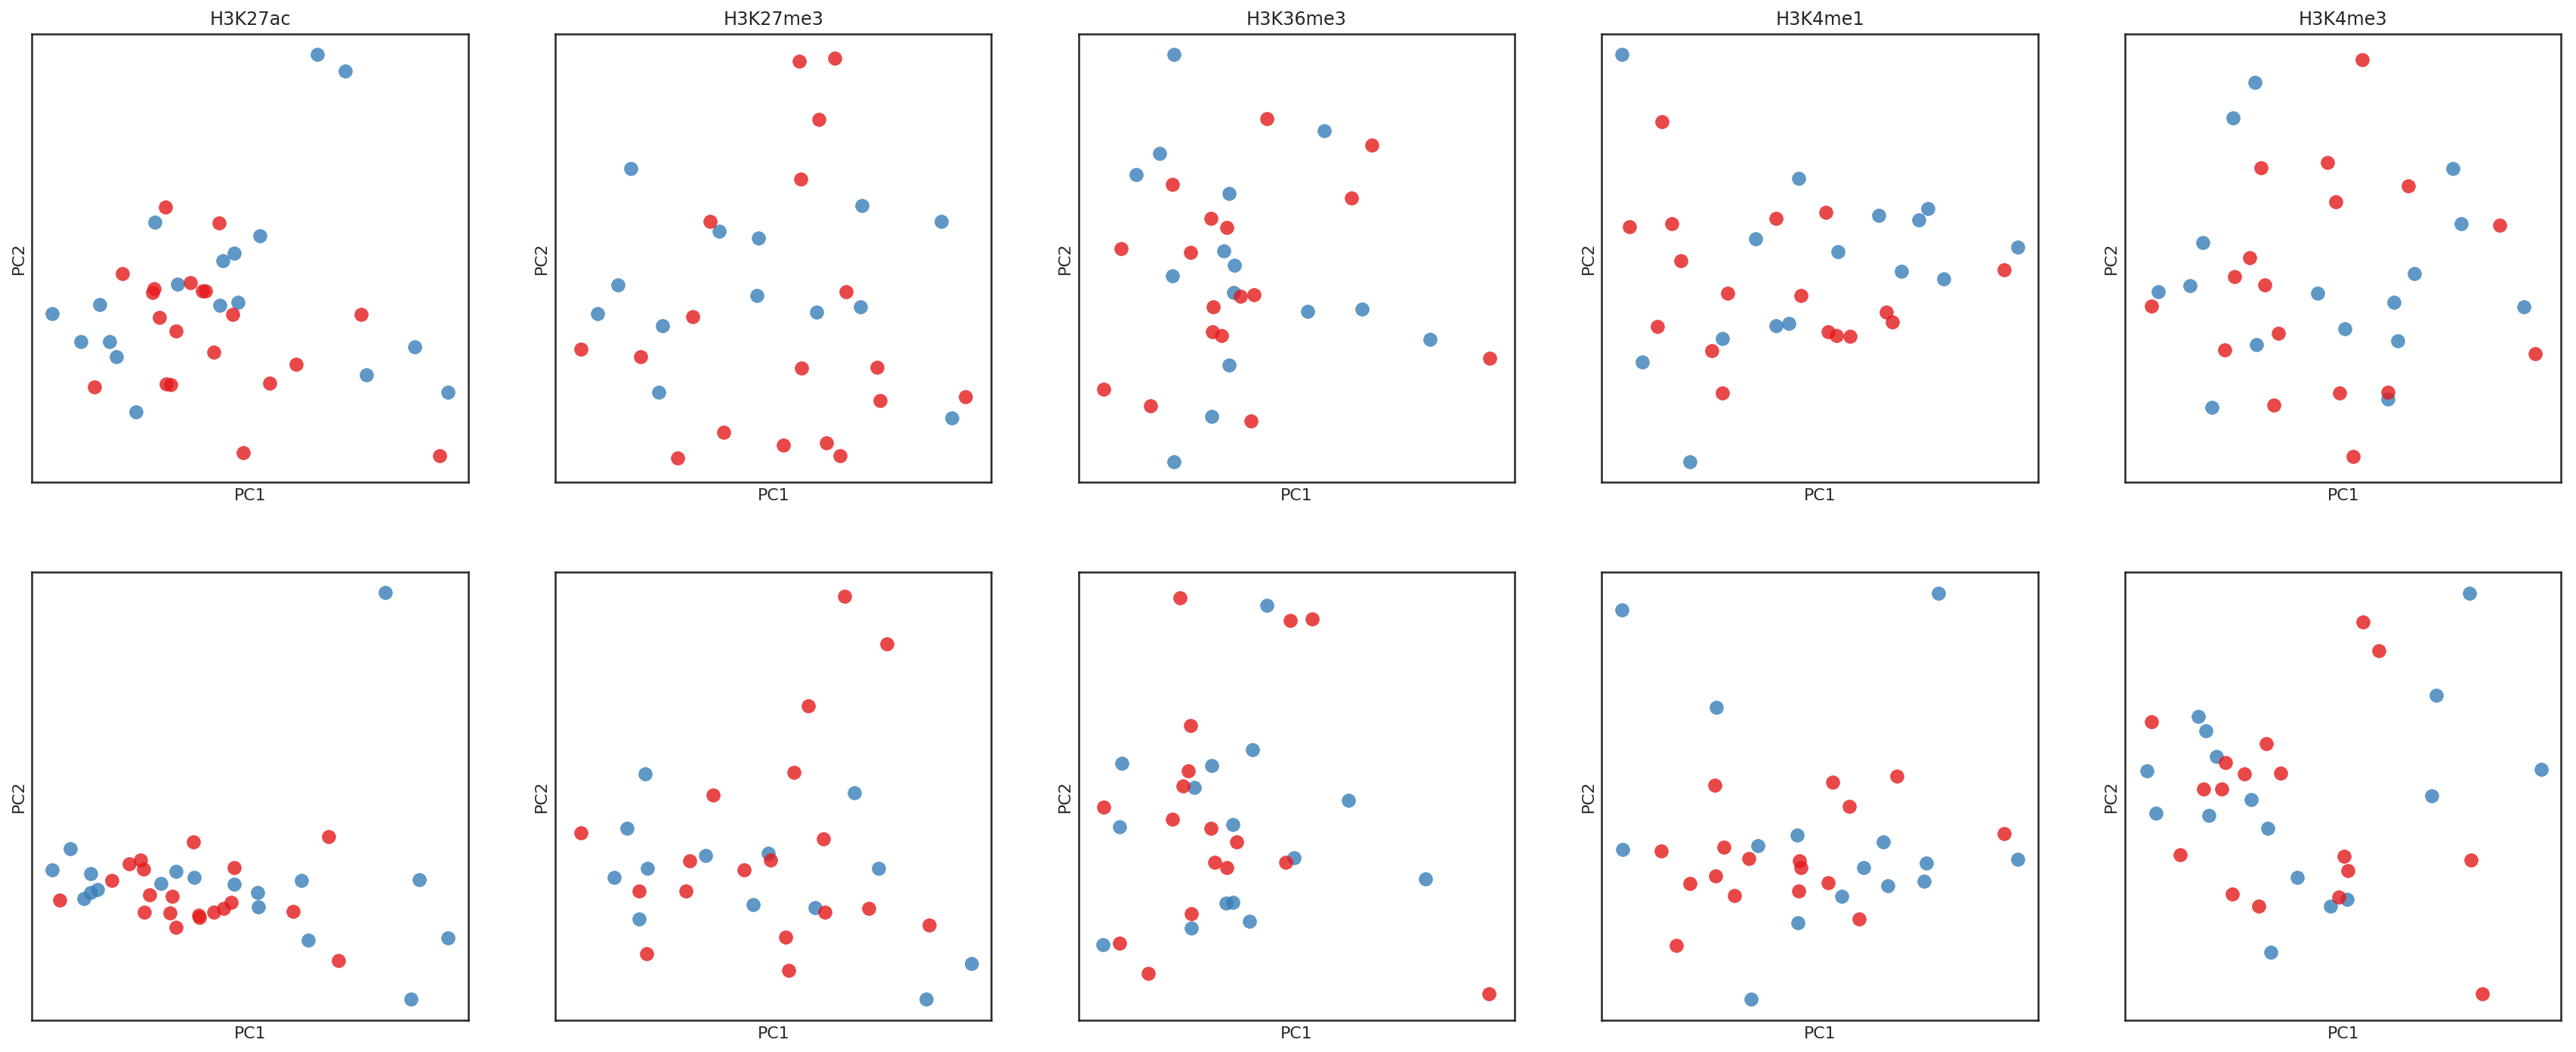

In [11]:
NORMALIZATIONS_ALL = [
#   'raw', 
  'rpm', 
#   'rpkm', 
#   'fripm',
#   'diffbind_tmm_minus_full', 
#   'diffbind_tmm_reads_full_cpm', 
#   'diffbind_tmm_reads_effective_cpm',
]               


PATHS=[
    ('Peaks', {mark: '/mnt/stripe/bio/experiments/signal_experiment/{0}/150/\
{0}_span_weak_consensus/{0}_span_weak_consensus.tsv'.format(mark) for mark in MARKS}),
    ('DMRs', {mark: '/mnt/stripe/bio/experiments/signal_experiment/{}/150/\
dmrs_filtered_ncyto_ge3_abs_avgdiff_ge0.025/dmrs_filtered_ncyto_ge3_abs_avgdiff_ge0.025.tsv'.format(mark) for mark in MARKS})
]


# A copy of washu_signal_pca with cosmetics
def signal_pca_plot_cosmetics(signal, ax):
    columns = signal.columns
    groups = [Group('Old', AGE_PALETTE['Old']) if str(d).startswith('OD') else Group('Young', AGE_PALETTE['Young']) for d in columns]
    # Data may contain "Inf" or "NaN" values for some rages, let's just skip
    # such values otherwise PCA will fail
    with pd.option_context('mode.use_inf_as_null', True):
        df = signal.dropna(how="any", axis=0).T
    pca = PCA(n_components=2)
    x_r = pca.fit_transform(df)
    for g in set(groups):
        group_filter = np.asarray([g == n for n in groups])
        ax.scatter(x_r[group_filter, 0], x_r[group_filter, 1],
                   color=g.color, alpha=.8, label=g.name, s=80)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])

MARKS_FOR_HEATMAP = ['H3K27ac', 'H3K27me3', 'H3K36me3', 'H3K4me1', 'H3K4me3']

sns.set(style='ticks')


print('Plotting everything on a single plot')
sns.set(style='ticks')
for norm in NORMALIZATIONS_ALL:
    pdf_path = '/mnt/stripe/figures/pca_peaks_dmrs_{}.pdf'.format(norm)
    print('Processing', pdf_path)
    with PdfPages(pdf_path) as pdf:
        fig, axes = plt.subplots(nrows=len(PATHS), 
                                 ncols=len(MARKS_FOR_HEATMAP), 
                                 figsize=(len(MARKS_FOR_HEATMAP)*6, 6 * len(PATHS)))
        for i, (name, paths) in enumerate(PATHS):
            for j, mark in enumerate(MARKS_FOR_HEATMAP):
                    ax = axes[i][j]
                    path = re.sub('\.tsv', '_{}.tsv'.format(norm), paths[mark])
                    print(path)
                    df = pd.read_csv(path, 
                                     sep='\t').drop(['chr', 'start', 'end'], axis=1)
                    signal = df[[c for c in df.columns.values if not is_input(c)]]
                    if norm == 'raw' or norm == 'rpm' or norm == 'rpkm':
                        singal = preprocessing.scale(signal)
                    signal_pca_plot_cosmetics(signal, ax=ax)

            for mark, ax in zip(MARKS_FOR_HEATMAP, axes[0]):
                ax.set_title(mark)
#         plt.show()
#         plt.close()
        pdf.savefig()


# Different Signals on DMRs up/down

Processing all at once
Average signal (over donors) per 1kbp raw
Processing /mnt/stripe/figures/foldchange_dmrs_raw.pdf
MannWhitney U H3K4me1 raw DMR Up vs DMR Down stat 426692.5 p 8.392916993191204e-37
MannWhitney U H3K27me3 raw DMR Up vs DMR Down stat 721707.5 p 2.5581484079870654e-10
MannWhitney U H3K27ac raw DMR Up vs DMR Down stat 372798.0 p 1.2752197261924148e-58
MannWhitney U H3K4me3 raw DMR Up vs DMR Down stat 583775.0 p 0.010527772108238046
MannWhitney U H3K36me3 raw DMR Up vs DMR Down stat 462282.5 p 3.0283607643485456e-25
Average signal (over donors) per 1kbp rpm
Processing /mnt/stripe/figures/foldchange_dmrs_rpm.pdf
MannWhitney U H3K4me1 rpm DMR Up vs DMR Down stat 427274.0 p 1.3519271739302361e-36
MannWhitney U H3K27me3 rpm DMR Up vs DMR Down stat 723616.0 p 1.1459773640846983e-10
MannWhitney U H3K27ac rpm DMR Up vs DMR Down stat 377883.0 p 2.435942224702584e-56
MannWhitney U H3K4me3 rpm DMR Up vs DMR Down stat 590159.0 p 0.0317990345307258
MannWhitney U H3K36me3 rpm DMR U

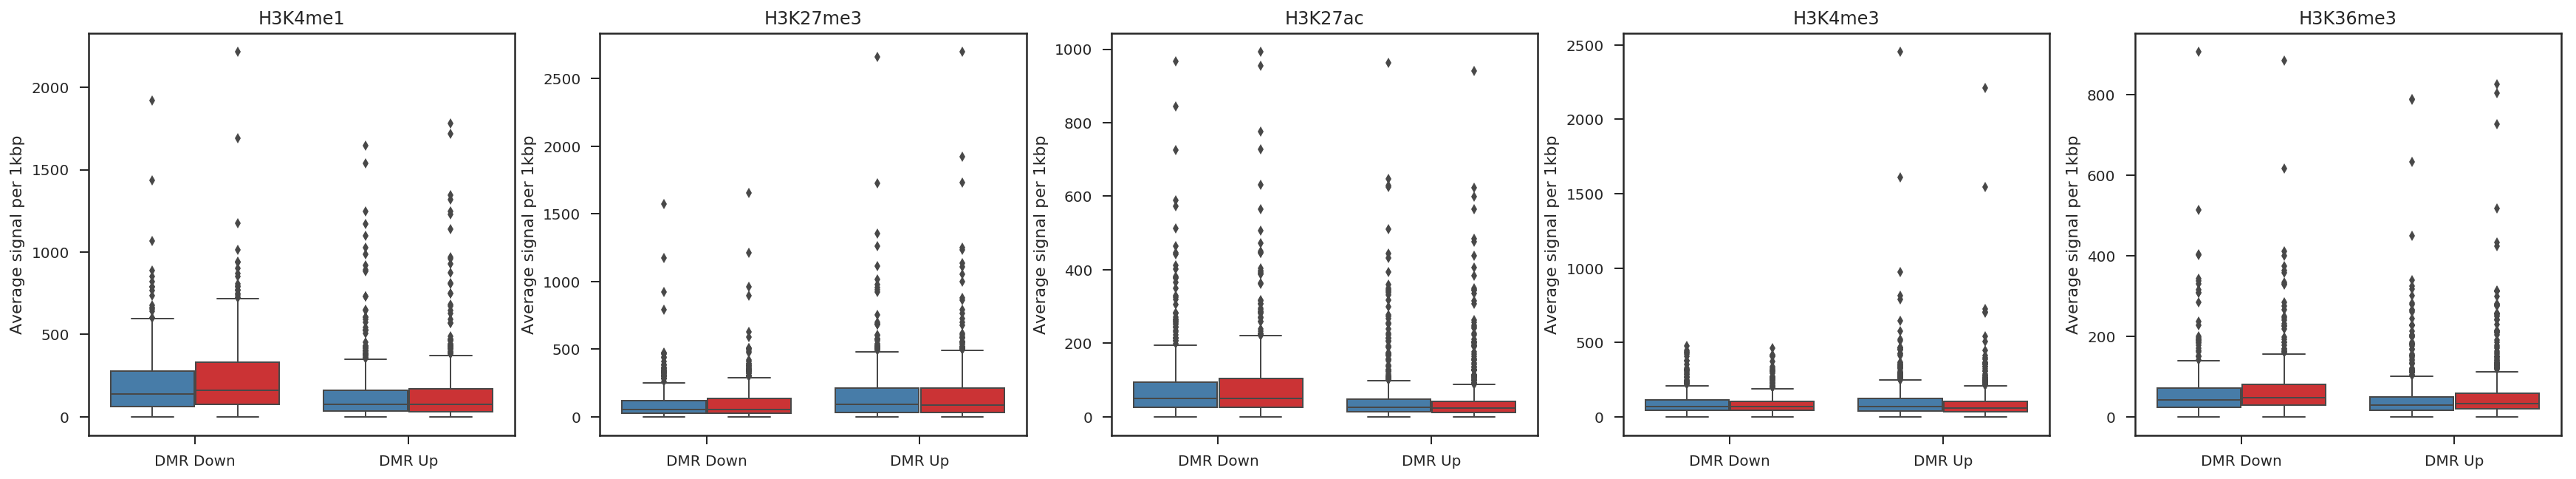

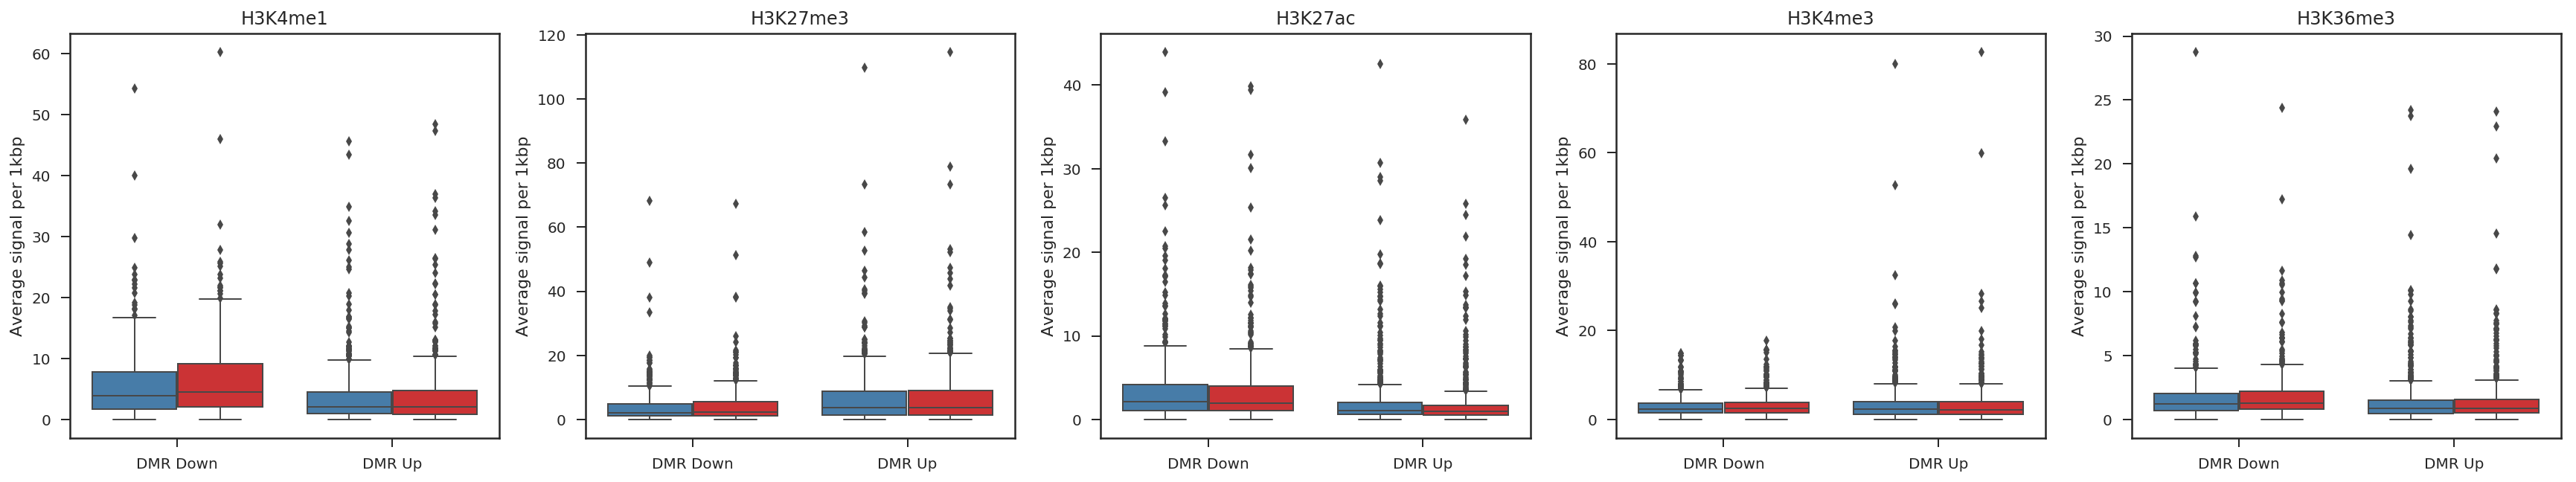

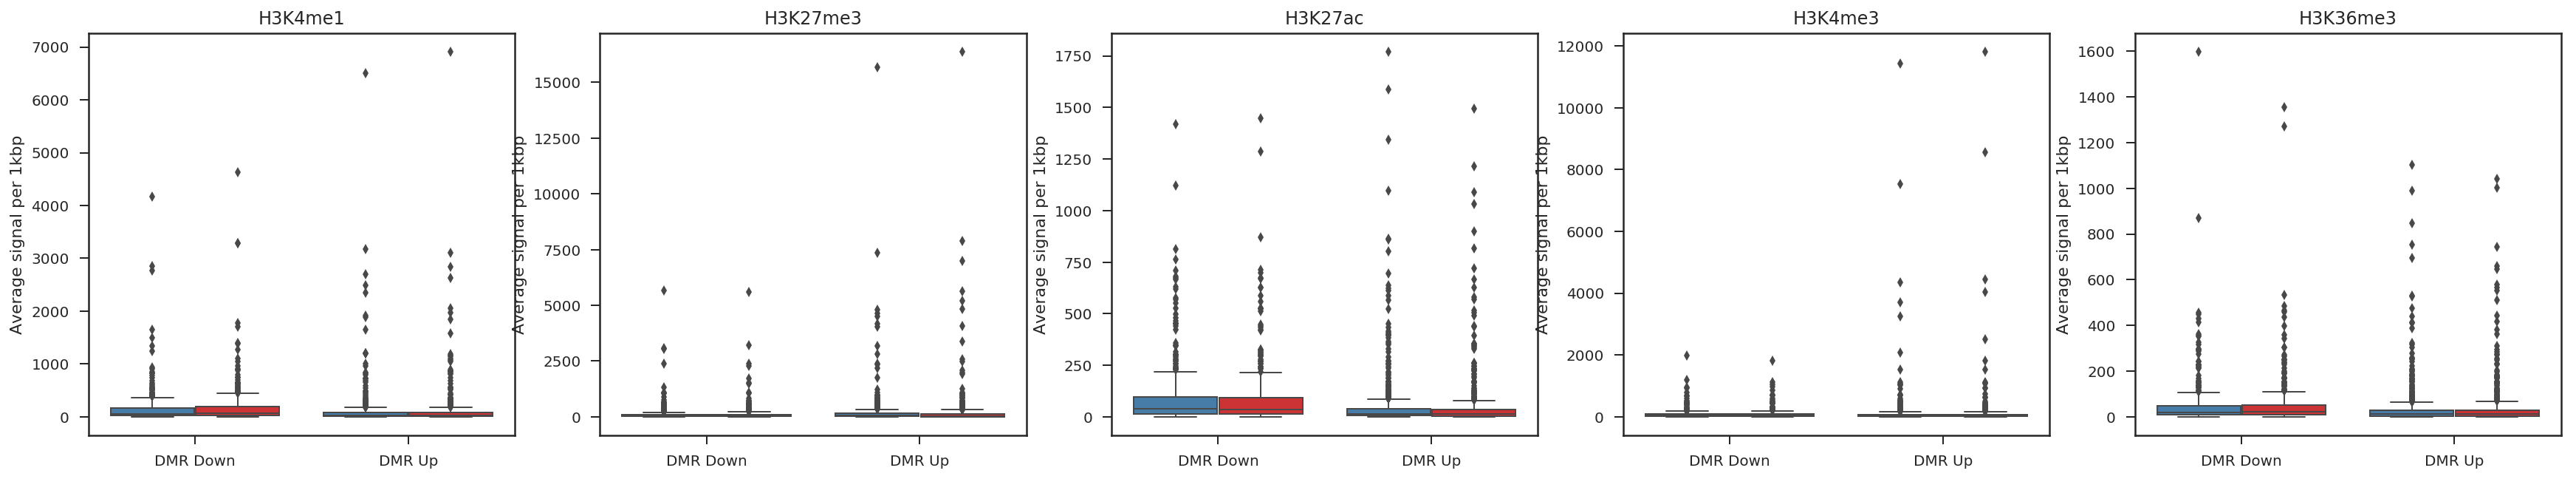

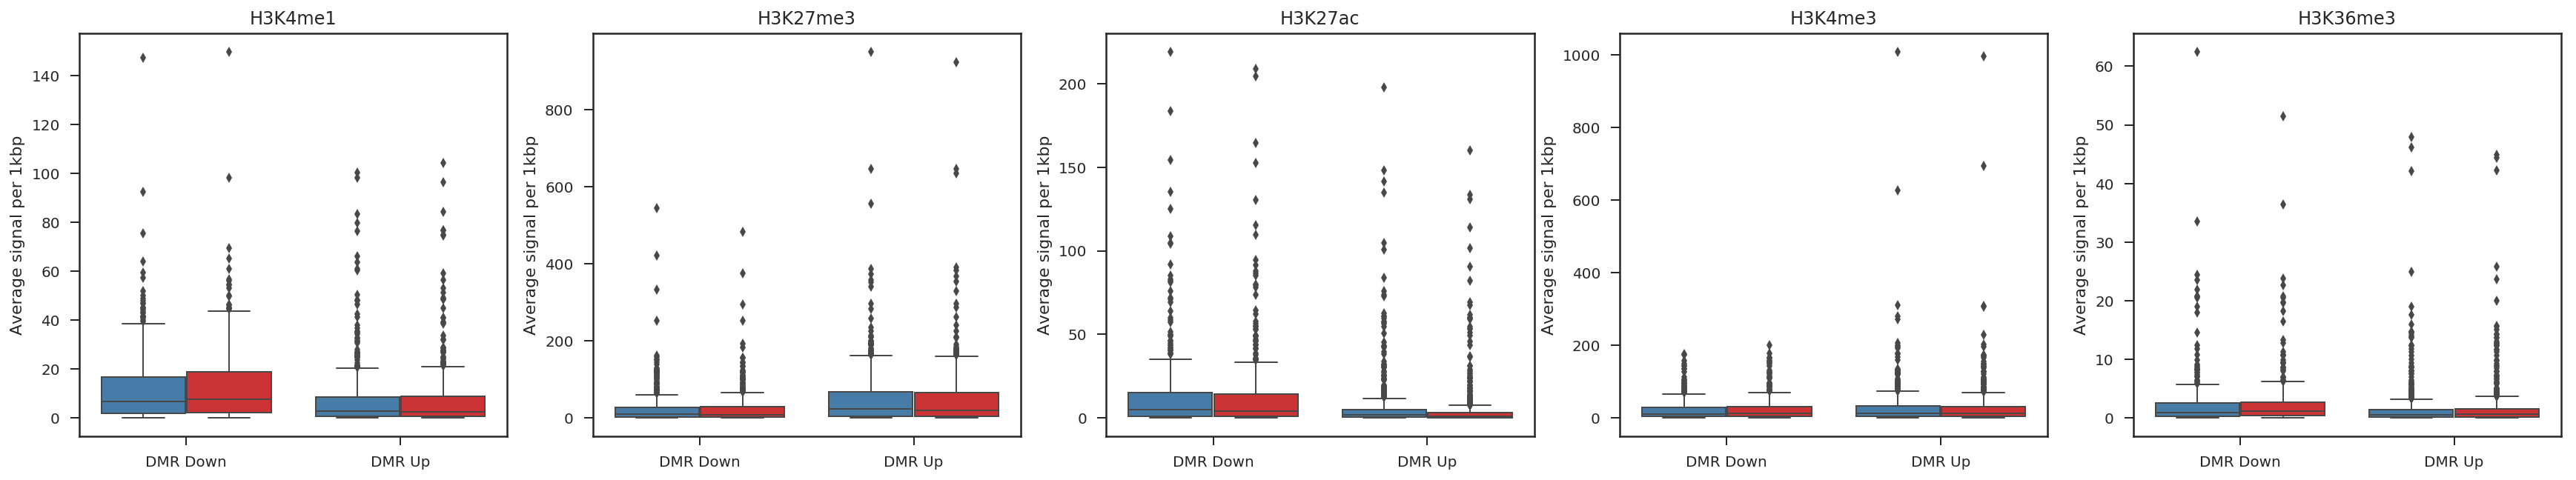

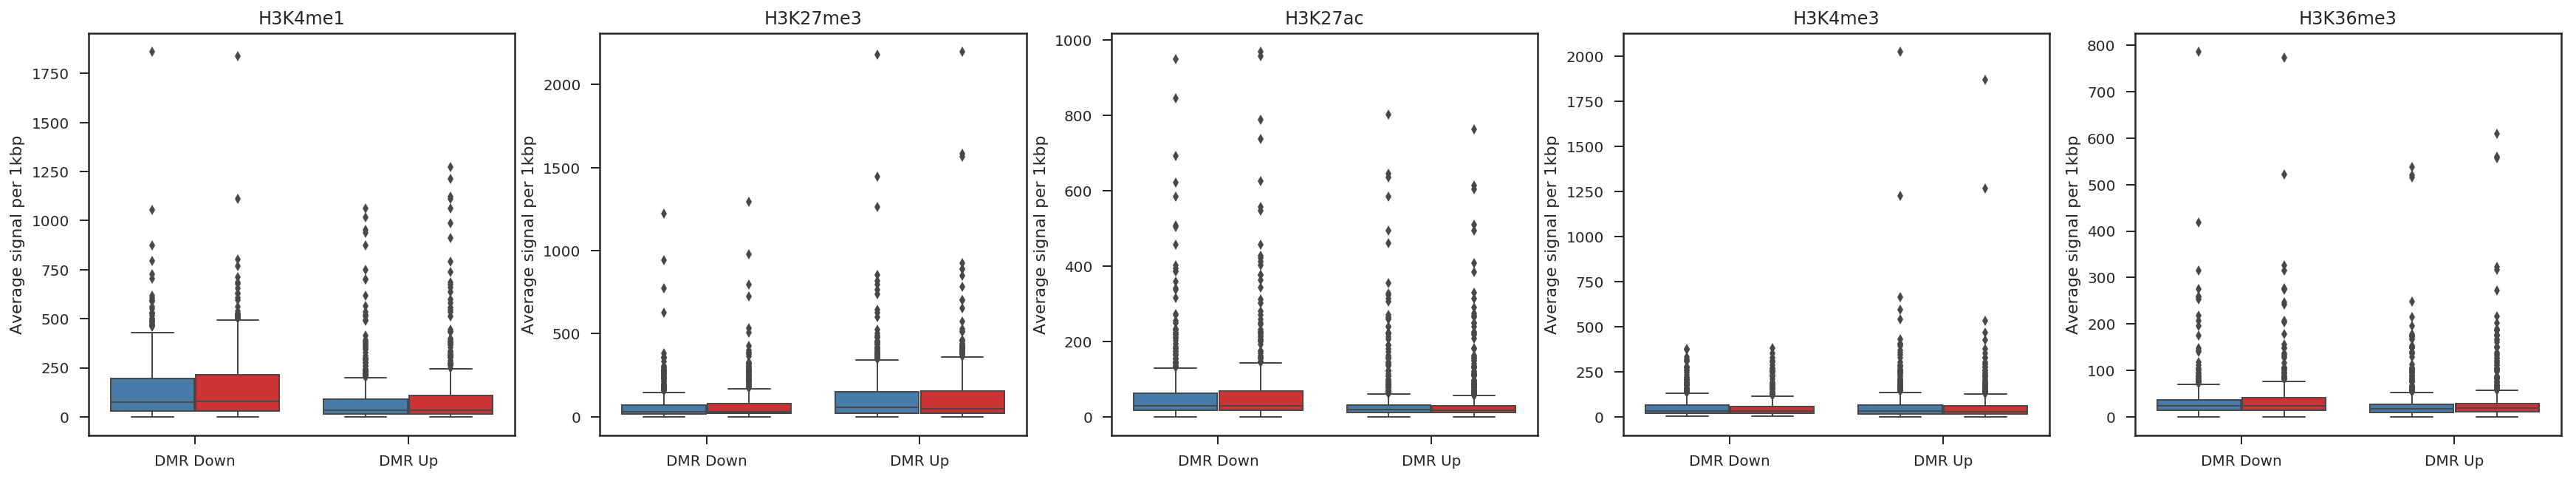

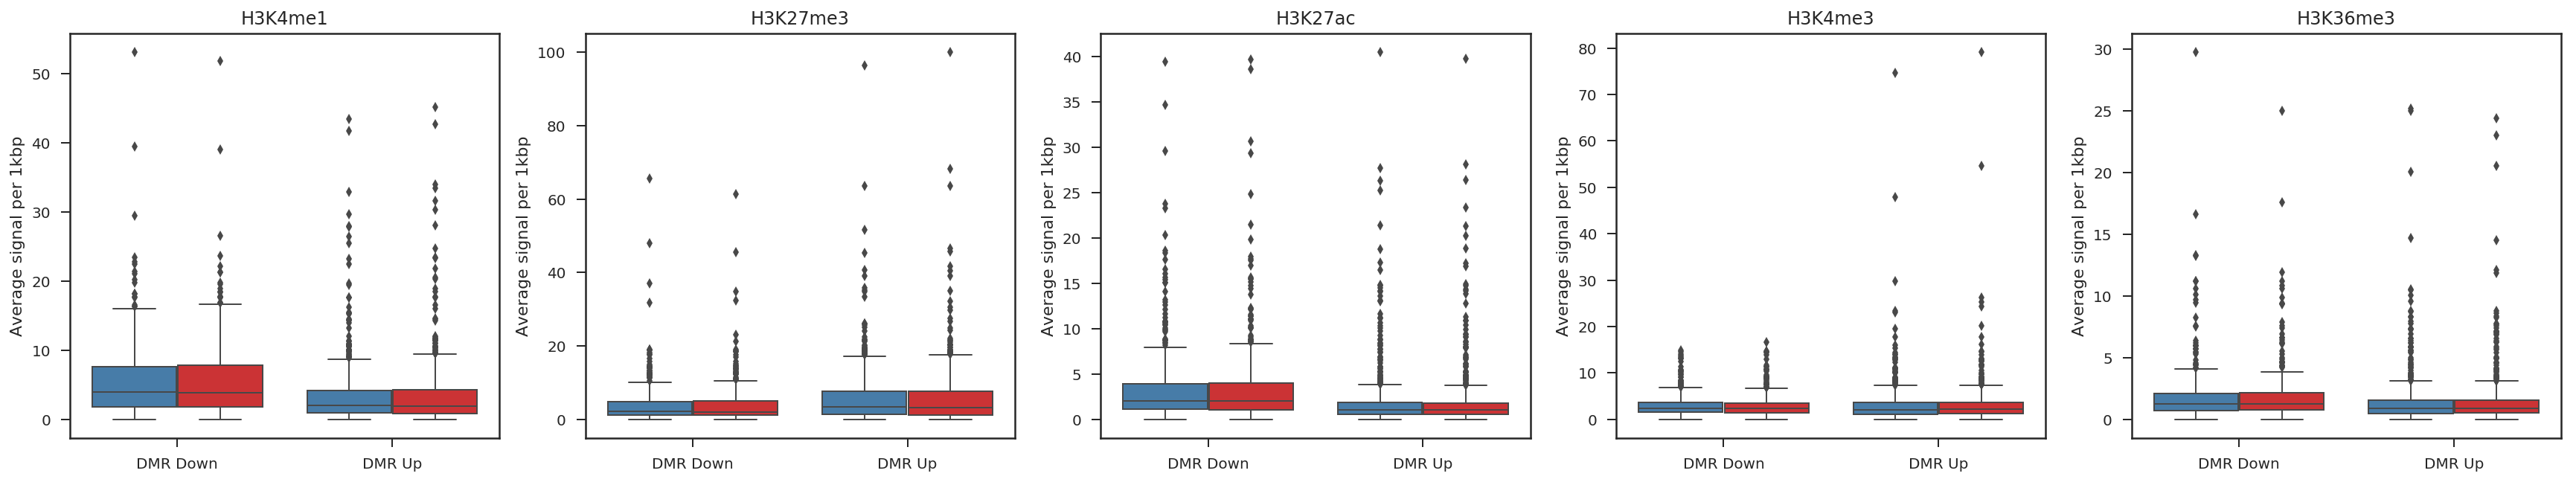

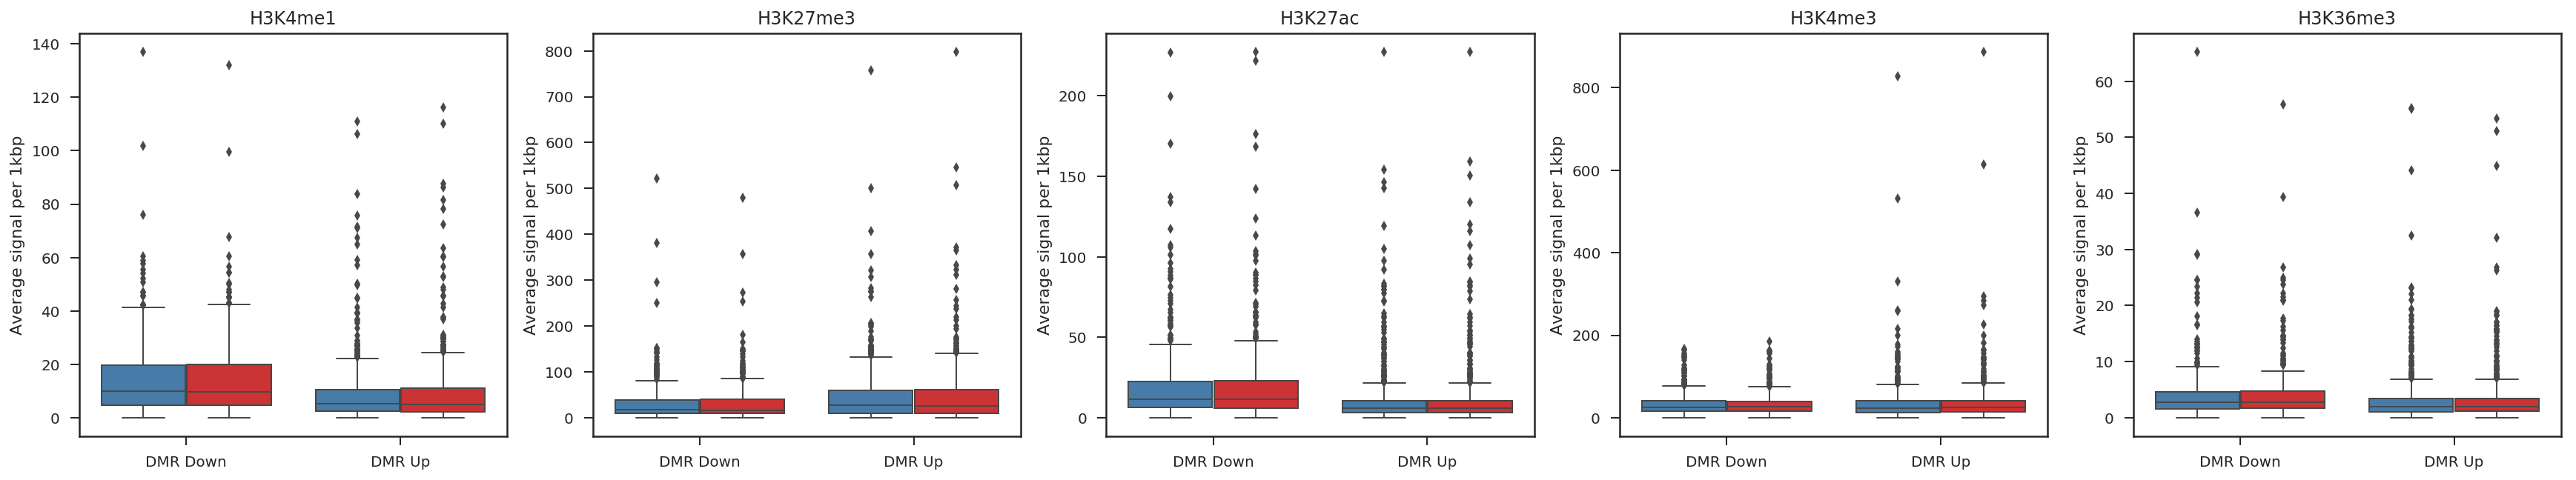

In [24]:
from scipy.stats import wilcoxon
from scipy.stats import mannwhitneyu

from collections import OrderedDict, Counter


DMR_PATHS = OrderedDict([ 
    ('DMR Up', {mark: '/mnt/stripe/bio/experiments/signal_experiment/{}/\
150/dmrs_filtered_ncyto_ge3_abs_avgdiff_ge0.025_up/dmrs_filtered_ncyto_ge3_abs_avgdiff_ge0.025_up.tsv'.format(mark) for mark in MARKS}),
    ('DMR Down', {mark: '/mnt/stripe/bio/experiments/signal_experiment/{}/\
150/dmrs_filtered_ncyto_ge3_abs_avgdiff_ge0.025_down/dmrs_filtered_ncyto_ge3_abs_avgdiff_ge0.025_down.tsv'.format(mark) for mark in MARKS}),
])

print('Processing all at once')
for norm in NORMALIZATIONS_ALL:
    print('Average signal (over donors) per 1kbp', norm)
    pdf_path = '/mnt/stripe/figures/foldchange_dmrs_{}.pdf'.format(norm)
    print('Processing', pdf_path)
    with PdfPages(pdf_path) as pdf:
        plt.figure(figsize=(len(MARKS_FOR_HEATMAP) * 6, 5))    
        for i, mark in enumerate(MARKS_FOR_HEATMAP):
            ax = plt.subplot(1, len(MARKS_FOR_HEATMAP), i + 1)
            dfs = {k : pd.read_csv(re.sub('\.tsv', '_{}.tsv'.format(norm), DMR_PATHS[k][mark]), 
                                 sep='\t') for k in DMR_PATHS.keys()}
            avg_signals = []
            for (age, selector) in [('Young', is_yd), ('Old', is_od)]:
                for k in dfs.keys():
                    df = dfs[k]
                    # Process average over donors signal
                    avg_signal = df[[c for c in df.columns if selector(c)]].mean(axis=1).to_frame('avg')
                    avg_signal['avg_per_1kbp'] = avg_signal['avg'] * 1000.0 / (df['end'] - df['start'])
                    avg_signal['Type'] = k
                    avg_signal['age'] = age
                    avg_signals.append(avg_signal)

            avg_signal = pd.concat(avg_signals)
            
            ups = avg_signal.loc[avg_signal['Type'] == 'DMR Up']['avg_per_1kbp']
            downs = avg_signal.loc[avg_signal['Type'] == 'DMR Down']['avg_per_1kbp']
            stat, p = mannwhitneyu(x = ups, y = downs, alternative='two-sided')
            print ('MannWhitney U', mark, norm, 'DMR Up vs DMR Down', 'stat', stat, 'p', p)

            sns.boxplot(data=avg_signal, 
                        x='Type', y='avg_per_1kbp', 
                        linewidth=1.0, 
                        hue='age',
                        ax = ax,
                        palette= AGE_PALETTE)
            ax.set_ylabel('Average signal per 1kbp')
            ax.set_xlabel('')
            ax.legend().set_visible(False)
            ax.set_title(mark)
        pdf.savefig()
#         plt.show()

# K27me3/K4me1 ratio on different DMRs up/down

In [ ]:
def plot_means_and_types(data):
    plt.figure(figsize=(20, 5))
    ax = plt.subplot(1, 4, 1)
    sns.boxplot(data=data, 
                x='age', y='ratio', 
                linewidth=1.0, 
                hue='type',
                ax = ax,
                palette="husl")

    axs = {}
    for i, t in enumerate(['All', 'Up', 'Down']):
        ax = plt.subplot(1, 4, i + 2)
        ax.set_title(t)
        ax.set_xlabel('k4me1')
        ax.set_ylabel('k27me3')
        for age, color in [('Young', 'red'), ('Old', 'blue') ]:
            d2p = data.loc[np.logical_and(data['type']==t, data['age']==age)]
            plt.scatter(d2p['k4me1'], d2p['k27me3'], color=color, alpha=0.3)    
        axs[ax] = (plt.xlim(), plt.ylim())
    xmin = np.min([x[0][0] for x in axs.values()])
    xmax = np.max([x[0][1] for x in axs.values()])
    ymin = np.min([x[1][0] for x in axs.values()])
    ymax = np.max([x[1][1] for x in axs.values()])
    for ax in axs.keys():
        ax.plot([xmin, xmax], [ymin, ymax], alpha=0.5, color='gray', linestyle='dotted')
    plt.show()



for norm in NORMALIZATIONS:
    print('Processing', norm)    
    mdfs = {}
    dfs_k27me3 = {k : pd.read_csv(re.sub('\.tsv', '_{}.tsv'.format(norm), DMR_PATHS[k]['H3K27me3']), 
                             sep='\t') for k in DMR_PATHS.keys()}
    dfs_k4me1 = {k : pd.read_csv(re.sub('\.tsv', '_{}.tsv'.format(norm), DMR_PATHS[k]['H3K4me1']), 
                             sep='\t') for k in DMR_PATHS.keys()}

    # Data for all the donors: donor data frame s    
    ddfs = []
    donor_names = []
    for (age, selector) in [('Old', is_od), ('Young', is_yd)]:
        for k in DMR_PATHS.keys():
            df_k27me3 = dfs_k27me3[k]
            df_k4me1 = dfs_k4me1[k]
            if any(df_k27me3['chr'] != df_k4me1['chr']) or\
                any(df_k27me3['start'] != df_k4me1['start']) or\
                any(df_k27me3['end'] != df_k4me1['end']):
                print('ERROR: wrong indices')
            # For each donor in intersection for each location compute ratio
            k27me3_donors = [re.sub('_H3K27me3', '', c) for c in df_k27me3.columns if selector(c)]
            k4me1_donors = [re.sub('_H3K4me1', '', c) for c in df_k4me1.columns if selector(c)]
            for cd in set(k27me3_donors).intersection(k4me1_donors):
                ddf = pd.DataFrame()
                ddf['chr'] = df_k27me3['chr']
                ddf['start'] = df_k27me3['start']
                ddf['end'] = df_k27me3['end']
                ddf['length'] = ddf['end'] - ddf['start']
                ddf['k27me3'] = df_k27me3[cd + '_H3K27me3']
                ddf['k4me1'] = df_k4me1[cd + '_H3K4me1']
                ddf['ratio'] = np.log((ddf['k27me3'] + 1e-6) / (ddf['k4me1'] + 1e-6))
                ddf['type'] = k
                ddf['age'] = age
                ddf['donor'] = cd

                if cd not in donor_names:
                    donor_names.append(cd)
                # Remove NA
                ddf = ddf.loc[np.isfinite(ddf['ratio'])]
                ddfs.append(ddf)

    signal = pd.concat(ddfs)
    print('Total recods', len(signal))

    #######################################################################################################
    # Data ################################################################################################
    #######################################################################################################
    print('Individual donors')     
    plt.figure(figsize=(20, 5))
    ax = plt.subplot(1, 1, 1)
    sns.boxplot(data=signal, 
                x='donor', y='ratio', 
                linewidth=1.0, 
                hue='type',
                ax = ax,
                order = donor_names,
                palette="husl")
    ax.set_xticklabels(donor_names, rotation = 90)
    ax.set_ylabel('log (K27me3 / K4me1)')
    plt.show()
    
    plot_means_and_types(signal)
    
    print('Average values')     
    avg_signal = pd.DataFrame(pd.pivot_table(signal, values=['k27me3', 'k4me1'], 
                                index=['chr', 'start', 'end', 'age', 'type'], aggfunc=np.mean).to_records())
    avg_signal['ratio'] = np.log((avg_signal['k27me3'] + 1e-6) / (avg_signal['k4me1'] + 1e-6))
    plot_means_and_types(avg_signal)

    #######################################################################################################
    # Data per 1kbp #######################################################################################
    #######################################################################################################
    print('Individual donors per 1kbp')     
    signal_1kbp = pd.DataFrame(signal)
    signal_1kbp['k27me3'] = signal_1kbp['k27me3'] * 1000.0 / signal_1kbp['length']
    signal_1kbp['k4me1'] = signal_1kbp['k4me1'] * 1000.0 / signal_1kbp['length']
    plot_means_and_types(signal_1kbp)

    print('Average values per 1kbp')     
    avg_signal_1kbp = pd.DataFrame(pd.pivot_table(signal_1kbp, values=['k27me3', 'k4me1'], 
                                index=['chr', 'start', 'end', 'age', 'type'], aggfunc=np.mean).to_records())
    avg_signal_1kbp['ratio'] = np.log((avg_signal_1kbp['k27me3'] + 1e-6) / (avg_signal_1kbp['k4me1'] + 1e-6))
    plot_means_and_types(avg_signal_1kbp)

# Code to analyze ratio of arbitrary marks

In [ ]:
def load_data(norm, pattern, mI, mJ):
    mI_path = pattern.format(mI, norm)
    df_mI = pd.read_csv(mI_path, sep='\t')

    mJ_path = pattern.format(mJ, norm)
    df_mJ = pd.read_csv(mJ_path, sep='\t')

    if any(df_mI['chr'] != df_mJ['chr']) or\
        any(df_mI['start'] != df_mJ['start']) or\
        any(df_mI['end'] != df_mJ['end']):
        print('ERROR: wrong indices')
        
    print(mI, mJ, 'number of regions', len(df_mI), 'average length', np.mean(df_mI['end'] - df_mI['start']))


    # Data for all the donors: donor data frame s 
    ddfs = []
    donor_names = []
    for (age, selector) in [('Old', is_od), ('Young', is_yd)]:
            # For each donor for each location compute ratio
            ratio_df = pd.DataFrame()
            mI_donors = [re.sub('_' + mI,'', c) for c in df_mI.columns if selector(c)]
            mJ_donors = [re.sub('_' + mJ,'', c) for c in df_mJ.columns if selector(c)]
            for cd in set(mI_donors).intersection(mJ_donors):
                ddf = pd.DataFrame()
                ddf['chr'] = df_mI['chr']
                ddf['start'] = df_mI['start']
                ddf['end'] = df_mI['end']
                ddf['length'] = ddf['end'] - ddf['start']
                ddf[mI] = df_mI[cd + '_' + mI]
                ddf[mJ] = df_mJ[cd + '_' + mJ]
                ddf['ratio'] = np.log((ddf[mI] + 1e-6) / (ddf[mJ] + 1e-6))
                ddf['age'] = age
                ddf['donor'] = cd
                if cd not in donor_names:
                    donor_names.append(cd)
                ddfs.append(ddf)

    data = pd.concat(ddfs)  
    print('Total records', len(data))
    return data, donor_names


def plot_individual_data(signal, donor_labels, mI, mJ):
    plt.figure(figsize=(30, 6))
    ax = plt.subplot(1, 5, 1)
    # Collect all the ratios into single dataframe to build PCA on them    
    df_for_pca = pd.DataFrame()
    for d in donor_labels:
        df_for_pca[d] = list(signal.loc[signal['donor'] == d]['ratio'])
    df_for_pca.fillna(value=0, inplace=True)

    # Remove NA
    signal = signal.loc[np.isfinite(signal['ratio'])]

    sns.boxplot(data=signal,
                x='donor', y='ratio', 
                linewidth=1.0,
                ax = ax, 
                hue='age',
                order=donor_labels,
                palette = "husl")
    ax.legend([], [])
    ax.set_xticklabels(labels=donor_labels, rotation=90)
    ax.set_ylabel('log ({} / {})'.format(mI, mJ))

    ax = plt.subplot(1, 5, 2)
    sns.distplot(signal.loc[signal['age']=='Young']['ratio'], 
                 bins=100, kde=False, rug=False, ax = ax, label='Young')
    sns.distplot(signal.loc[signal['age']=='Old']['ratio'], 
                 bins=100, kde=False, rug=False, ax = ax, label='Old')
    ax.legend()
    ax.set_xlabel('log ({} / {})'.format(mI, mJ))

    ax = plt.subplot(1, 5, 3)
    signal_pca_plot(df_for_pca, 'PCA log ({} / {})'.format(mI, mJ), ax)

    x = 4
    axs = {}
    for age, color in [('Young', 'red'), ('Old', 'blue')]:
        ax = plt.subplot(1, 5, x)
        x += 1
        ax.set_xlabel(mI)
        ax.set_ylabel(mJ)
        s2p = signal.loc[signal['age']==age]
        print('Total records', age, len(s2p))
        plt.scatter(s2p[mI], s2p[mJ], color=color, alpha=0.3)
        axs[ax] = (plt.xlim(), plt.ylim())

    xmin = np.min([x[0][0] for x in axs.values()])
    xmax = np.max([x[0][1] for x in axs.values()])
    ymin = np.min([x[1][0] for x in axs.values()])
    ymax = np.max([x[1][1] for x in axs.values()])
    for ax in axs.keys():
        ax.plot([xmin, xmax], [ymin, ymax], alpha=0.5, color='gray', linestyle='dotted')

    plt.show()


def plot_average_data(avg_signal, mI, mJ):
    plt.figure(figsize=(16, 4))
    ax = plt.subplot(1, 4, 1)
    # Remove NA
    avg_signal = avg_signal.loc[np.isfinite(avg_signal['ratio'])]
    sns.boxplot(data=avg_signal, 
                x='age', y='ratio', 
                linewidth=1.0,
                ax = ax, 
                palette = "husl")
    ax.legend([], [])
    ax.set_ylabel('log ({} / {})'.format(mI, mJ))

    ax = plt.subplot(1, 4, 2)
    sns.distplot(avg_signal.loc[avg_signal['age']=='Young']['ratio'], 
                 bins=100, kde=False, rug=False, ax = ax, label='Young')
    sns.distplot(avg_signal.loc[avg_signal['age']=='Old']['ratio'], 
                 bins=100, kde=False, rug=False, ax = ax, label='Old')
    ax.legend()
    ax.set_xlabel('log ({} / {})'.format(mI, mJ))

    x = 3
    axs = {}
    for age, color in [('Young', 'red'), ('Old', 'blue')]:
        ax = plt.subplot(1, 4, x)
        x += 1
        ax.set_xlabel('avg ' + mI + ' per 1kbp')
        ax.set_ylabel('avg ' + mJ + ' per 1kbp')
        s2p = avg_signal.loc[avg_signal['age']==age]
        print('Total records', age, len(s2p))
        plt.scatter(s2p[mI], s2p[mJ], color=color, alpha=0.3)
        axs[ax] = (plt.xlim(), plt.ylim())

    xmin = np.min([x[0][0] for x in axs.values()])
    xmax = np.max([x[0][1] for x in axs.values()])
    ymin = np.min([x[1][0] for x in axs.values()])
    ymax = np.max([x[1][1] for x in axs.values()])
    for ax in axs.keys():
        ax.plot([xmin, xmax], [ymin, ymax], alpha=0.5, color='gray', linestyle='dotted')

    plt.show()    
    
    


def analyze_ratio(normalizations, pattern, mI, mJ):
    """ For all the donors for which we have mI and mJ measurement we analyze distribution
        of mark mI and mJ over regions of interest: pattern
    """
    for norm in normalizations:
        print('Processing', norm, mI, mJ)    
        signal, donor_names = load_data(norm, pattern, mI, mJ) 

        #######################################################################################################
        # Raw Data ############################################################################################
        #######################################################################################################
        print('Individual donors', mI, mJ, norm)
        plot_individual_data(signal, donor_names, mI, mJ)
        
        print('Average over donors', mI, mJ, norm)        
        avg_signal = pd.DataFrame(pd.pivot_table(signal, values=[mI, mJ], 
                                  index=['chr', 'start', 'end', 'age'], aggfunc=np.mean).to_records())
        avg_signal['ratio'] = np.log((avg_signal[mI] + 1e-6) / (avg_signal[mJ] + 1e-6))
        print('Total records', len(avg_signal))
        plot_average_data(avg_signal, mI, mJ)

        #######################################################################################################
        # Data per 1kbp #######################################################################################
        #######################################################################################################
        print('Individual donors per 1kbp', mI, mJ, norm)
        signal_1kbp = pd.DataFrame(signal)
        signal_1kbp[mI] = signal_1kbp[mI] * 1000.0 / signal_1kbp['length']
        signal_1kbp[mJ] = signal_1kbp[mJ] * 1000.0 / signal_1kbp['length']
        plot_individual_data(signal_1kbp, donor_names, mI, mJ)


        print('Average over donors per 1kbp', mI, mJ, norm)        
        avg_signal_1kbp = pd.DataFrame(pd.pivot_table(signal_1kbp, values=[mI, mJ], 
                                      index=['chr', 'start', 'end', 'age'], aggfunc=np.mean).to_records())
        avg_signal_1kbp['ratio'] = np.log((avg_signal_1kbp[mI] + 1e-6) / (avg_signal_1kbp[mJ] + 1e-6))
        print('Total records', len(avg_signal_1kbp))
        plot_average_data(avg_signal_1kbp, mI, mJ)



## Peaks concatenation
```
cat /mnt/stripe/bio/raw-data/aging/loci_of_interest/median_consensus/H3K27me3_span_median_consensus.bed > /mnt/stripe/bio/raw-data/aging/loci_of_interest/median_consensus/concat_H3K27me3_H3K4me1_span_median_consensus.bed

cat /mnt/stripe/bio/raw-data/aging/loci_of_interest/median_consensus/H3K4me1_span_median_consensus.bed  >> /mnt/stripe/bio/raw-data/aging/loci_of_interest/median_consensus/concat_H3K27me3_H3K4me1_span_median_consensus.bed

cat  /mnt/stripe/bio/raw-data/aging/loci_of_interest/median_consensus/concat_H3K27me3_H3K4me1_span_median_consensus.bed | awk 'BEGIN{L=0;N=0}{L=L+$3-$2;N=N+1} END{print(N,L,L/N)}'
66186 195128400 2948.18
```

In [ ]:
analyze_ratio(NORMALIZATIONS,
'/mnt/stripe/bio/experiments/signal_experiment/{}/150/\
concat_H3K27me3_H3K4me1_span_median_consensus/concat_H3K27me3_H3K4me1_span_median_consensus_{}.tsv',
             'H3K27me3', 'H3K4me1')

# K27me3 K4me1 on Peaks simmetrical difference
```
bash /mnt/stripe/washu/bed/minus.sh /mnt/stripe/bio/raw-data/aging/loci_of_interest/median_consensus/H3K27me3_span_median_consensus.bed /mnt/stripe/bio/raw-data/aging/loci_of_interest/median_consensus/H3K4me1_span_median_consensus.bed > /mnt/stripe/bio/raw-data/aging/loci_of_interest/median_consensus/simmetrical_diff_H3K27me3_H3K4me1_span_median_consensus.bed
# 3097 K27me3 not in K4me1

bash /mnt/stripe/washu/bed/minus.sh /mnt/stripe/bio/raw-data/aging/loci_of_interest/median_consensus/H3K4me1_span_median_consensus.bed /mnt/stripe/bio/raw-data/aging/loci_of_interest/median_consensus/H3K27me3_span_median_consensus.bed >> /mnt/stripe/bio/raw-data/aging/loci_of_interest/median_consensus/simmetrical_diff_H3K27me3_H3K4me1_span_median_consensus.bed
# 59509 - 3097 not in K27me3

cat  /mnt/stripe/bio/raw-data/aging/loci_of_interest/median_consensus/simmetrical_diff_H3K27me3_H3K4me1_span_median_consensus.bed | awk 'BEGIN{L=0;N=0}{L=L+$3-$2;N=N+1} END{print(N,L,L/N)}'
59509 159289800 2676.73
```

In [ ]:
analyze_ratio(NORMALIZATIONS,
'/mnt/stripe/bio/experiments/signal_experiment/{}/150/\
simmetrical_diff_H3K27me3_H3K4me1_span_median_consensus/simmetrical_diff_H3K27me3_H3K4me1_span_median_consensus_{}.tsv',
             'H3K27me3', 'H3K4me1')

# K27me3 to K4me1 ratio on ChromHMM state Enh Biv

In [ ]:
# analyze_ratio(NORMALIZATIONS,
# '/mnt/stripe/bio/experiments/signal_experiment/{}/150/\
# cd14_encsr907lcd_chromhmm18.hg19.15_EnhBiv/cd14_encsr907lcd_chromhmm18.hg19.15_EnhBiv_{}.tsv',
#              'H3K27me3', 'H3K4me1')

# Code to build signals for given mark and bed regions

In [ ]:
# Build missing signals

from scripts.util import run
import os
MARKS = ['H3K27ac', 'H3K27me3', 'H3K36me3', 'H3K4me1', 'H3K4me3']
PEAKS_WC_PT = '/mnt/stripe/bio/raw-data/aging/loci_of_interest/weak_consensus/{}_span_weak_consensus.bed'
PEAKS_MC_PT = '/mnt/stripe/bio/raw-data/aging/loci_of_interest/median_consensus/{}_span_median_consensus.bed'

def build_signals(m, peaks_wc, bed):
    if os.path.exists('/mnt/stripe/bio/experiments/signal_experiment/{}/150/{}'.format(
        m, re.sub('\.bed', '', os.path.basename(bed)))):
        print('Signals already exist', m, peaks_wc, bed)
        return
    
    print('Build signals', m, peaks_wc, bed)
    run([["bash", 
          '/mnt/stripe/washu/downstream/signals/signals.sh',
          '/mnt/stripe/bio/experiments/signal_experiment/{}'.format(m), 
          '150',
          bed, 
          '/mnt/stripe/bio/genomes/hg19/hg19.chrom.sizes',
          peaks_wc]])

# Different marks analysis on peaks concat

For each pair of marks:
* Concat peaks
* Launch signals for these 2 marks
* Build analysis

In [ ]:
# Peaks concat
for i in range(0, len(MARKS)):
    mI = MARKS[i]
    for j in range(i + 1, len(MARKS)):
        mJ = MARKS[j]
        print()
        print('Processing', mI, 'vs', mJ)
        concat_path = '/mnt/stripe/bio/raw-data/aging/loci_of_interest/median_consensus/\
concat_{}_{}_span_median_consensus.bed'.format(mI, mJ)
        peaks_mcI = PEAKS_MC_PT.format(mI)
        peaks_mcJ = PEAKS_MC_PT.format(mJ)
        print('Concat peaks', peaks_mcI, peaks_mcJ, 'to', concat_path)
        run([["bash", '-c', 'cat {} > {}'.format(peaks_mcI, concat_path)]])
        run([["bash", '-c', 'cat {} >> {}'.format(peaks_mcJ, concat_path)]])
 
        build_signals(mI, PEAKS_WC_PT.format(mI), concat_path)
        build_signals(mJ, PEAKS_WC_PT.format(mJ), concat_path)

In [ ]:
for i in range(0, len(MARKS)):
    mI = MARKS[i]
    for j in range(i + 1, len(MARKS)):
        mJ = MARKS[j]
        print()
        print('Processing', mI, 'vs', mJ)
        path = 'concat_{0}_{1}_span_median_consensus/concat_{0}_{1}_span_median_consensus'.format(mI, mJ)
        analyze_ratio(NORMALIZATIONS,
'/mnt/stripe/bio/experiments/signal_experiment/{}/150/' + path + '_{}.tsv',
             mI, mJ)

# Marks ratios on peaks intersection

For each pair of marks:
* Intersect peaks
* Launch signals for these 2 marks
* Build analysis

In [ ]:
# Peaks intersection
for i in range(0, len(MARKS)):
    mI = MARKS[i]
    for j in range(i + 1, len(MARKS)):
        mJ = MARKS[j]
        print()
        print('Processing', mI, 'vs', mJ)
        intersect_path = '/mnt/stripe/bio/raw-data/aging/loci_of_interest/median_consensus/\
intersect_{}_{}_span_median_consensus.bed'.format(mI, mJ)
        peaks_mcI = PEAKS_MC_PT.format(mI)
        peaks_mcJ = PEAKS_MC_PT.format(mJ)
        print('Intersect peaks', peaks_mcI, peaks_mcJ, 'to', intersect_path)
        run([["bash", '-c', 'bash /mnt/stripe/washu/bed/intersect.sh {} {} > {}'.
              format(peaks_mcI, peaks_mcJ, intersect_path)]])
 
        build_signals(mI, PEAKS_WC_PT.format(mI), intersect_path)
        build_signals(mJ, PEAKS_WC_PT.format(mJ), intersect_path)

In [ ]:
# Launch on intersection of peaks
for i in range(0, len(MARKS)):
    mI = MARKS[i]
    for j in range(i + 1, len(MARKS)):
        mJ = MARKS[j]
        print()
        path = 'intersect_{0}_{1}_span_median_consensus/intersect_{0}_{1}_span_median_consensus'.format(mI, mJ)
        print()
        print('###################################################################################################')
        print()
        analyze_ratio(NORMALIZATIONS,
'/mnt/stripe/bio/experiments/signal_experiment/{}/150/' + path + '_{}.tsv',
             mI, mJ)
print('DONE')